### Make a non-random baseline for real vs. fake before DeepSonar using the online keyword recognition audio tutorial.

There is actually code for this, and it's not so trivial like a random baseline. Tutorial: https://www.tensorflow.org/tutorials/audio/simple_audio

### CNN baseline (make chapter here before uploading)

In [1]:
# turns on the GPU for tensorflow
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin") # tf can now see the GPU

<AddedDllDirectory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin')>

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns

In [4]:
tf.__version__

'2.10.0'

In [5]:
AUDIO_LENGTH_SECONDS = 4 # right now, we are cutting off all examples at a constant length

In [6]:
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/training/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000*AUDIO_LENGTH_SECONDS
)
label_names = np.array(train_ds.class_names)

Found 53868 files belonging to 2 classes.


In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 64000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
# convert data to mono (for-norm is mono), this just means one channel
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 64000)
(64,)


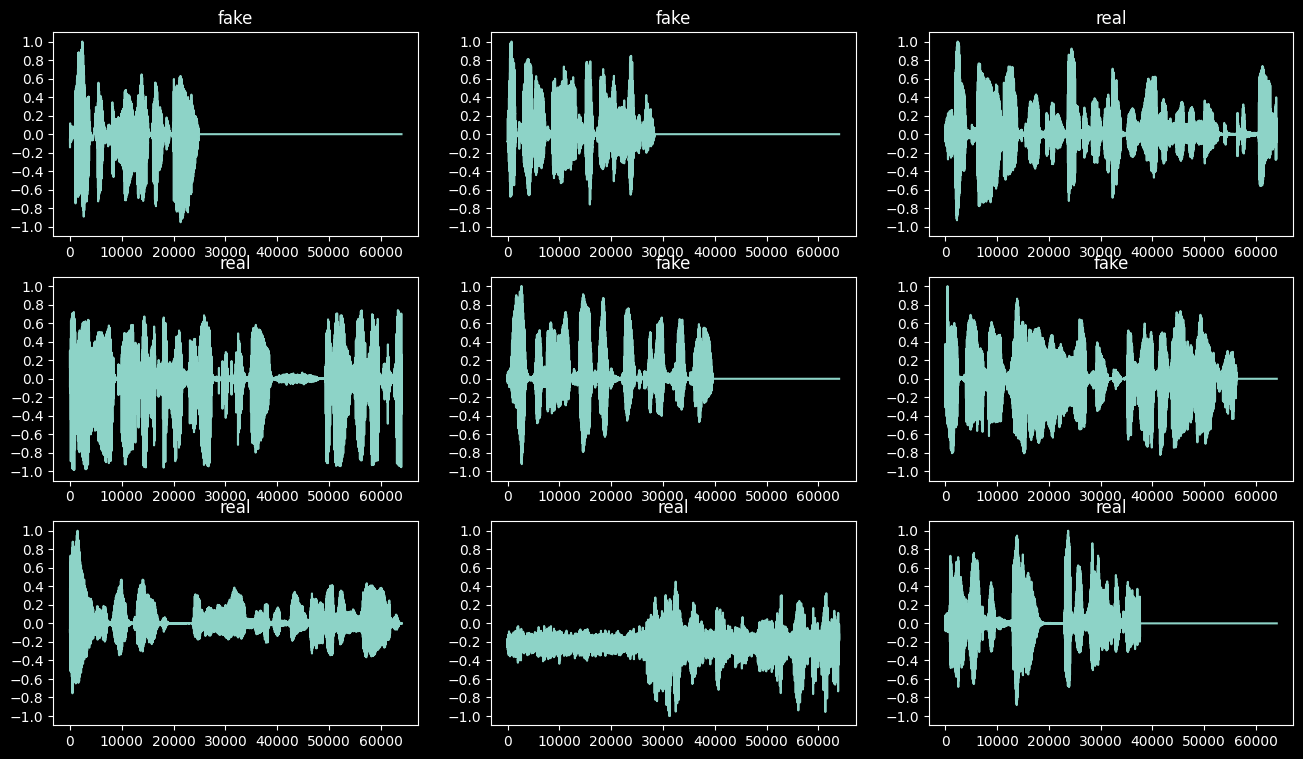

In [10]:
# visualize waveforms
plt.style.use("dark_background")
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i>=n:
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

plt.show()

In [11]:
# view the sample rate of the audio files? nah, just train DeepSonar for now.
for example_audio, example_labels in train_ds.take(1): 
    print(type(example_audio)) 
    print(example_audio.shape)
    print(example_labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 64000)
(64,)


In [12]:
# convert stuff to spectrograms
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)

    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [13]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


Label: real
Waveform shape: (64000,)
Spectrogram shape: (499, 129, 1)
Audio playback


In [14]:
def plot_spectrogram(spectrogram, ax):

    # error checking
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)

    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

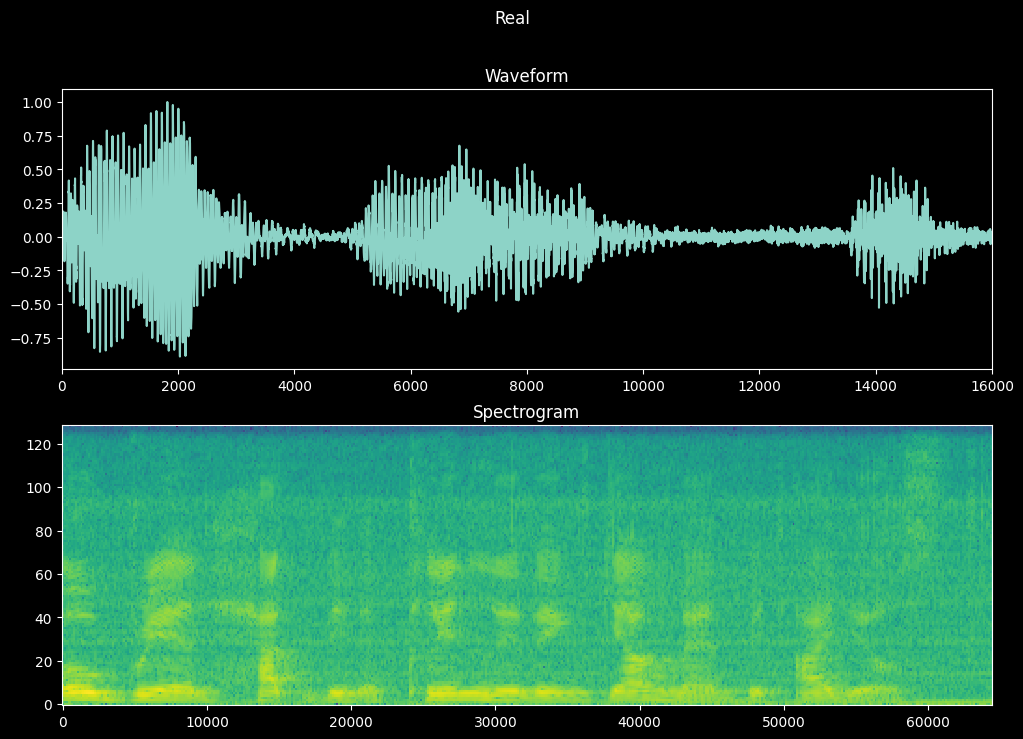

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [16]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)

In [18]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

In [19]:
label_names

array(['fake', 'real'], dtype='<U4')

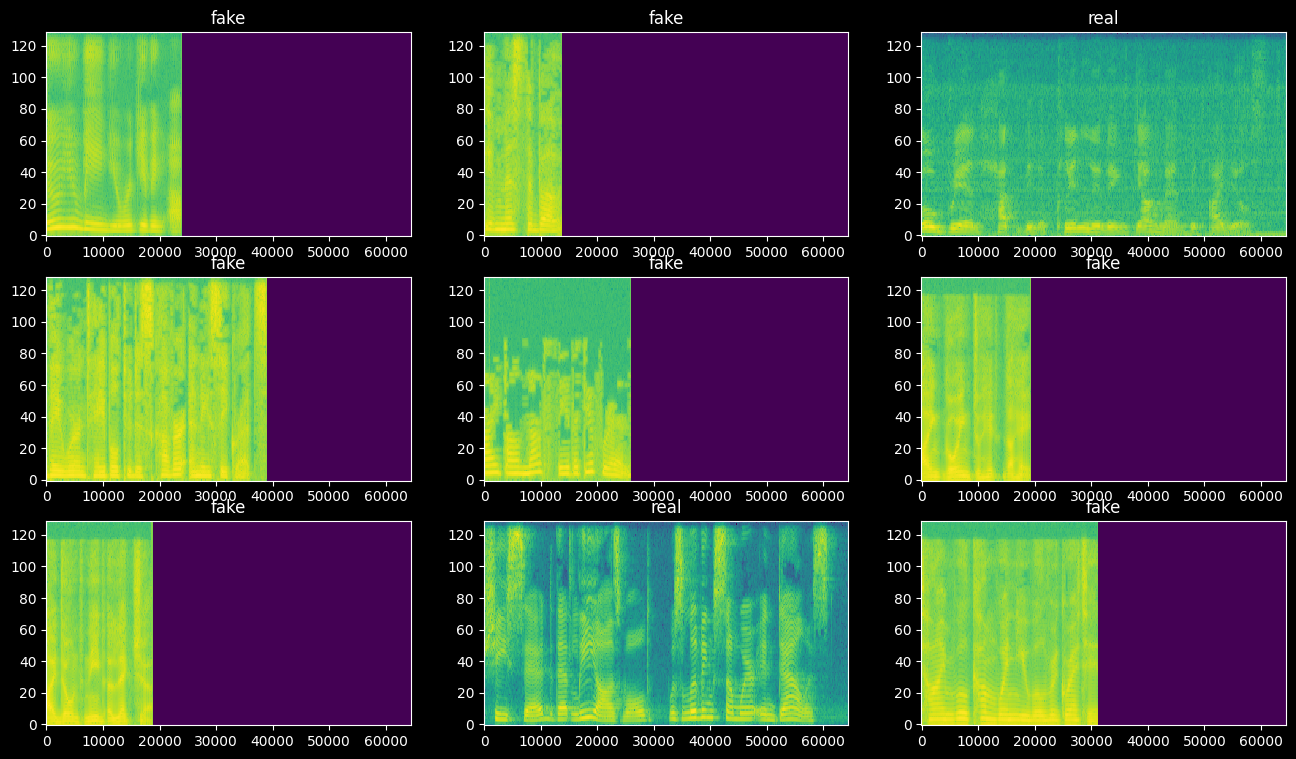

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()

# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (499, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
# need val data
val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/validation/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000*AUDIO_LENGTH_SECONDS
)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
val_spectrogram_ds = make_spec_ds(val_ds)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 10798 files belonging to 2 classes.


In [25]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
842/842 [==============================] - 24s 24ms/step - loss: 0.3032 - accuracy: 0.8778 - val_loss: 0.2049 - val_accuracy: 0.9164
Epoch 2/10
842/842 [==============================] - 12s 14ms/step - loss: 0.1510 - accuracy: 0.9444 - val_loss: 0.1082 - val_accuracy: 0.9596
Epoch 3/10
842/842 [==============================] - 12s 15ms/step - loss: 0.0949 - accuracy: 0.9660 - val_loss: 0.0737 - val_accuracy: 0.9737
Epoch 4/10
842/842 [==============================] - 12s 15ms/step - loss: 0.0689 - accuracy: 0.9754 - val_loss: 0.0641 - val_accuracy: 0.9758
Epoch 5/10
842/842 [==============================] - 11s 13ms/step - loss: 0.0546 - accuracy: 0.9805 - val_loss: 0.0565 - val_accuracy: 0.9809
Epoch 6/10
842/842 [==============================] - 11s 14ms/step - loss: 0.0433 - accuracy: 0.9848 - val_loss: 0.0487 - val_accuracy: 0.9831
Epoch 7/10
842/842 [==============================] - 11s 14ms/step - loss: 0.0390 - accuracy: 0.9863 - val_loss: 0.0557 - val_accuracy:

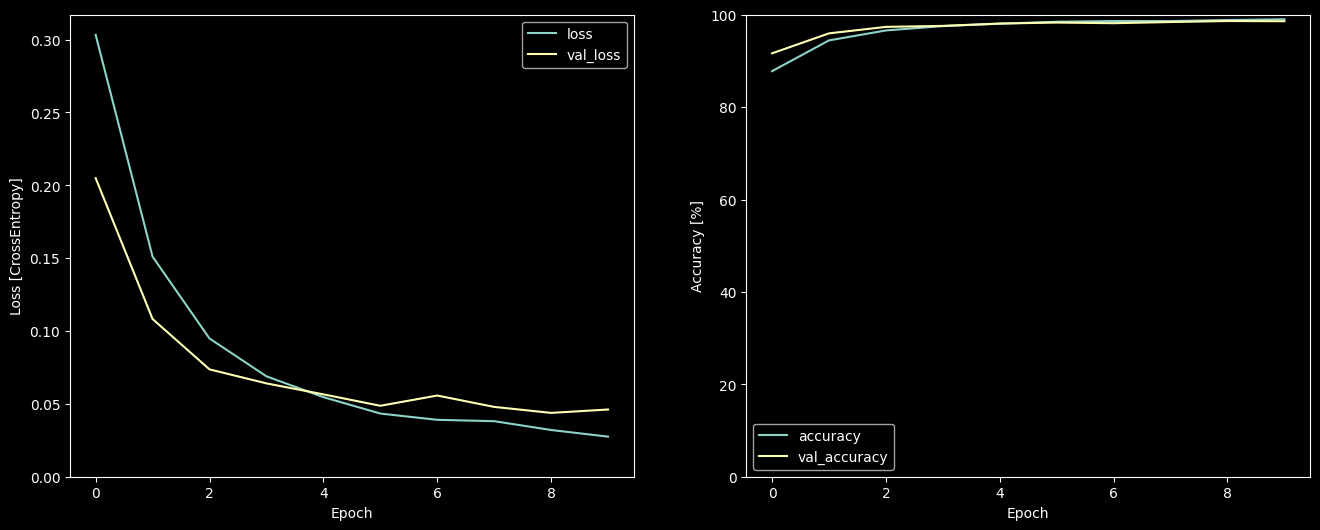

In [26]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy [%]')

In [27]:
# let's see testing accuracy
# need test dataset
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory="D:/for-norm/testing/",
    batch_size=64,
    validation_split=0,
    seed=0,
    output_sequence_length=16000*AUDIO_LENGTH_SECONDS
)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)
test_spectrogram_ds = make_spec_ds(test_ds)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Found 4634 files belonging to 2 classes.


In [28]:
model.evaluate(test_spectrogram_ds, return_dict=True)

73/73 [==============================] - 5s 59ms/step - loss: 0.3564 - accuracy: 0.8871


{'loss': 0.3564363718032837, 'accuracy': 0.8871385455131531}

In [29]:
y_pred = model.predict(test_spectrogram_ds)

73/73 [==============================] - 1s 10ms/step


In [30]:
y_pred = tf.argmax(y_pred, axis=1)

In [31]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

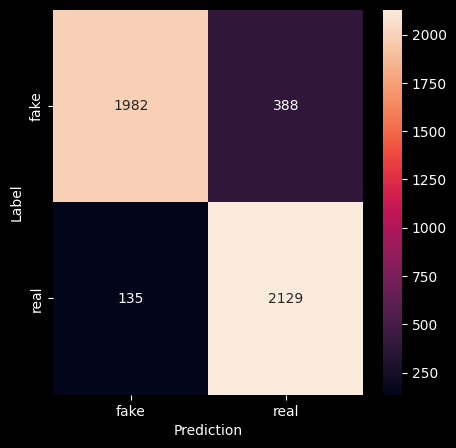

In [32]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Train DeepSonar

In [33]:
import sys
sys.path.append("../src/")
from deepsonar_model import get_deepsonar_model

In [34]:
# need to look at shapes of convolutional layers
# this first or the denoising autoencoder first?
# error is in vgg_sr_model.py, line 341
deepsonar = get_deepsonar_model()



Input Dim: (499, 129, 1)




c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


successfully loaded model & weights.


In [35]:
deepsonar.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 499, 129, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1/3x3_s1 (Conv2D)        (None, 499, 129, 64  3136        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv1_1/3x3_s1/bn (BatchNormal  (None, 499, 129, 64  256        ['conv1_1/3x3_s1[0][0]']         
 ization)                       )                                                           

In [36]:
deepsonar.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [37]:
EPOCHS = 10
history = deepsonar.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1906, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2544.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Cameron\AppData\Local\Temp\ipykernel_54300\2282909100.py", line 2, in <module>
      history = deepsonar.fit(
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\Cameron\vandy\research\code\deepsonar\env\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [1,1] and labels shape [64]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_58251]